<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 ! pip install -q kaggle
 from google.colab import files 

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d astronautelvis/kc-house-data
! mkdir Data
! unzip kc-house-data.zip -d Data

  0% 0.00/812k [00:00<?, ?B/s]
100% 812k/812k [00:00<00:00, 53.7MB/s]
Archive:  kc-house-data.zip
  inflating: Data/kc_final.csv       


In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output


In [ ]:
df = pd.read_csv("/content/Data/kc_final.csv", index_col=0)
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [ ]:
df.shape

(21613, 21)

# Categorical features

bedrooms

In [ ]:
df['bedrooms'].value_counts().shape[0]

13

In [ ]:
def get_bedrooms(data):
    num_classes = df['bedrooms'].value_counts().shape[0]
    return list(utils.to_categorical(max(0, min(12,data)), num_classes).astype('int'))

bathrooms

In [ ]:
def get_bathrooms(data):
    num_classes = 10
    outClass = int(data + 0.5)
    return list(utils.to_categorical(max(0, min(12,outClass)), num_classes).astype('int'))

floors

In [ ]:
def get_floors(data):
    num_classes = 5
    outClass = int(data + 0.5)
    return list(utils.to_categorical(max(0, min(12,outClass)), num_classes).astype('int'))

waterfront

In [ ]:
def get_waterfront(data):
    out = [0,0]
    out[data] = 1
    return out

condition

In [ ]:
def get_condition(data):
    out = list(np.zeros(df['condition'].max(), dtype='int'))
    out[data - 1] = 1
    return out

grade

In [ ]:
def get_grade(data):
    out = list(np.zeros(df['grade'].max(), dtype='int'))
    out[data - 1] = 1
    return out

yr_built

In [ ]:
def get_yr_built(data):
    build_age = int((2015 - data) / 10)
    out = list(np.zeros(12, dtype='int'))
    out[build_age] = 1
    return out

yr_renovated

In [ ]:
def get_yr_renovated(data):
    return [0, 1] if data > 0 else [0, 0]

view

In [ ]:
def get_view(data):
    out = list(np.zeros(5, dtype='int'))
    out[data] = 1
    return out

# continuous features

sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15

In [ ]:
sqft_living_scaler = StandardScaler()
df['sqft_living_scaled'] = sqft_living_scaler.fit_transform(df['sqft_living'].values.reshape(-1, 1))


In [ ]:
sqft_lot_scaler = StandardScaler()
df['sqft_lot_scaled'] = sqft_lot_scaler.fit_transform(df['sqft_lot'].values.reshape(-1, 1))

In [ ]:
sqft_above_scaler = StandardScaler()
df['sqft_above_scaled'] = sqft_above_scaler.fit_transform(df['sqft_above'].values.reshape(-1, 1))

In [ ]:
sqft_basement_scaler = StandardScaler()
df['sqft_basement_scaled'] = sqft_basement_scaler.fit_transform(df['sqft_basement'].values.reshape(-1, 1))

In [ ]:
lat_scaler = StandardScaler()
df['lat_scaled'] = lat_scaler.fit_transform(df['lat'].values.reshape(-1, 1))

In [ ]:
long_scaler = StandardScaler()
df['long_scaled'] = long_scaler.fit_transform(df['long'].values.reshape(-1, 1))

In [ ]:
sqft_living15_scaler = StandardScaler()
df['sqft_living15_scaled'] = sqft_living15_scaler.fit_transform(df['sqft_living15'].values.reshape(-1, 1))

In [ ]:
sqft_lot15_scaler = StandardScaler()
df['sqft_lot15_scaled'] = sqft_lot15_scaler.fit_transform(df['sqft_lot15'].values.reshape(-1, 1))

# create dataset

In [ ]:
cat_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']
cont_cols = ['sqft_living_scaled', 'sqft_lot_scaled', 'sqft_above_scaled', 'sqft_basement_scaled', 'lat_scaled', 'long_scaled', 'sqft_living15_scaled',
       'sqft_lot15_scaled']

In [ ]:
def create_vector(row):
    bedrooms = get_bedrooms(row['bedrooms'])
    bathrooms = get_bathrooms(row['bathrooms'])
    floors = get_floors(row['floors'])
    waterfront = get_waterfront(row['waterfront'])
    view = get_view(row['view'])
    condition = get_condition(row['condition'])
    grade = get_grade(row['grade'])
    yr_built = get_yr_built(row['yr_built'])
    yr_renovated = get_yr_renovated(row['yr_renovated'])

    out = []
    out += bedrooms
    out += bathrooms
    out += floors
    out += waterfront
    out += view
    out += condition
    out += grade
    out += yr_built
    out += yr_renovated

    for col in cont_cols:
        out.append(row[col])

    return np.array(out)


In [ ]:
df['res'] = df.progress_apply(create_vector, axis=1)

100%|██████████| 21613/21613 [00:20<00:00, 1057.35it/s]


In [ ]:
x_train = pd.DataFrame.from_records(df['res'].values).values

In [ ]:
y_train = (df['price']).values

In [ ]:
# Размер набора параметров 
print(x_train.shape) 
print(y_train.shape)
# Пример обработанных данных
n = 0 
print(x_train[n])
print(y_train[n])

(21613, 75)
(21613,)
[ 0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.         -0.97983502 -0.22832133 -0.73470764 -0.65868104 -0.35257175
 -0.30607896 -0.9433552  -0.26071541]
221900.0


Нейронка без стандартизации таргета

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
575/575 - 5s - loss: 417462255616.0000 - mae: 533245.6875 - val_loss: 477446144000.0000 - val_mae: 578796.8750
Epoch 2/100
575/575 - 1s - loss: 417421262848.0000 - mae: 533210.8750 - val_loss: 477371891712.0000 - val_mae: 578737.8750
Epoch 3/100
575/575 - 1s - loss: 417343471616.0000 - mae: 533142.4375 - val_loss: 477272440832.0000 - val_mae: 578654.3125
Epoch 4/100
575/575 - 1s - loss: 417250869248.0000 - mae: 533056.9375 - val_loss: 477170434048.0000 - val_mae: 578565.3750
Epoch 5/100
575/575 - 1s - loss: 417156235264.0000 - mae: 532967.5000 - val_loss: 477070950400.0000 - val_mae: 578477.5000
Epoch 6/100
575/575 - 1s - loss: 417063469056.0000 - mae: 532878.3125 - val_loss: 476973924352.0000 - val_mae: 578391.9375
Epoch 7/100
575/575 - 1s - loss: 416972308480.0000 - mae: 532790.6875 - val_loss: 476877291520.0000 - val_mae: 578306.7500
Epoch 8/100
575/575 - 1s - loss: 416881508352.0000 - mae: 532704.1250 - val_loss: 476780068864.0000 - val_mae: 578221.6875
Epoch 9/100
575/

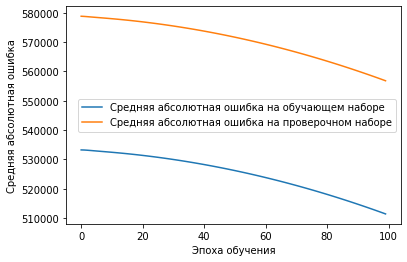

In [ ]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(x_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_split=0.15, 
                    verbose=2)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = model.predict(x_train)
pred = pred.flatten()
# Среднее значение ошибки 
delta = pred - y_train
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

518083.3839554753


Нейронка со стандартизацией таргета и двумя входами: для категориальных данных и для непрерывных

In [ ]:
# В качестве нормализации данных используем готовую библиотеку 
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yTrainScaled = yScaler.fit_transform(y_train.reshape(-1, 1))

print(yTrainScaled.shape)
print(y_train[1])
print(yTrainScaled[1])

(21613, 1)
538000.0
[-0.00568792]


In [ ]:
def create_vector_categorical(row):
    bedrooms = get_bedrooms(row['bedrooms'])
    bathrooms = get_bathrooms(row['bathrooms'])
    floors = get_floors(row['floors'])
    waterfront = get_waterfront(row['waterfront'])
    view = get_view(row['view'])
    condition = get_condition(row['condition'])
    grade = get_grade(row['grade'])
    yr_built = get_yr_built(row['yr_built'])
    yr_renovated = get_yr_renovated(row['yr_renovated'])

    out = []
    out += bedrooms
    out += bathrooms
    out += floors
    out += waterfront
    out += view
    out += condition
    out += grade
    out += yr_built
    out += yr_renovated

    return np.array(out)

In [ ]:
def create_vector_cont(row):
    out = []
    for col in cont_cols:
        out.append(row[col])
    return np.array(out)

In [ ]:
x_train_cat = pd.DataFrame.from_records(df.progress_apply(create_vector_categorical, axis=1).values).values

100%|██████████| 21613/21613 [00:19<00:00, 1094.54it/s]


In [ ]:
x_train_cont = pd.DataFrame.from_records(df.progress_apply(create_vector_cont, axis=1).values).values

100%|██████████| 21613/21613 [00:00<00:00, 28550.09it/s]


In [ ]:
print(x_train_cat.shape)
print(x_train_cont.shape)
print(x_train_cat[0])
print(x_train_cont[0])

(21613, 67)
(21613, 8)
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[-0.97983502 -0.22832133 -0.73470764 -0.65868104 -0.35257175 -0.30607896
 -0.9433552  -0.26071541]


In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+3 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
xTrainScaled = x_train_cont.copy()
xTrainC01 = x_train_cat.copy()
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [ ]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae]
                    )

print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=100, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae]
                    )

print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=100, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae]
                    )




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Эпоха 0 модуль ошибки 100.099
Эпоха 1 модуль ошибки 98.213
Эпоха 2 модуль ошибки 86.02
Эпоха 3 модуль ошибки 82.453
Эпоха 4 модуль ошибки 81.698
Эпоха 5 модуль ошибки 80.771
Эпоха 6 модуль ошибки 79.656
Эпоха 7 модуль ошибки 80.959
Эпоха 8 модуль ошибки 77.654
Эпоха 9 модуль ошибки 76.793
Эпоха 10 модуль ошибки 79.632
Эпоха 11 модуль ошибки 76.248
Эпоха 12 модуль ошибки 74.52
Эпоха 13 модуль ошибки 76.091
Эпоха 14 модуль ошибки 75.557
Эпоха 15 модуль ошибки 73.619
Эпоха 16 модуль ошибки 76.008
Эпоха 17 модуль ошибки 74.816
Эпоха 18 модуль ошибки 82.221
Эпоха 19 модуль ошибки 75.453
Эпоха 20 модуль ошибки 74.42
Эпоха 21 модуль ошибки 75.022
Эпоха 22 модуль ошибки 75.863
Эпоха 23 модуль ошибки 74.868
Эпоха 24 модуль ошибки 75.897
Эпоха 25 модуль ошибки 75.26
Эпоха 26 модуль ошибки 75.124
Эпоха 27 модуль ошибки 76.88
Эпоха 28 модуль ошибки 75.126
Эпоха 29 модуль ошибки 76.051
Эпоха 30 модуль ошибки 75.47
Эпоха 31 модуль ошибки 75.082
Эпоха 32 модуль ошибки 75.657
Эпоха 33 модуль ошибки 76

In [ ]:
#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+3 * len(absDelta))) #Выводим усреднённую ошибку в тысячах



Модуль ошибки 78.81394499635662


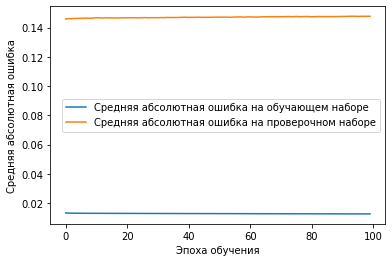

In [ ]:
#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Вывод: если не нормировать таргет, то сеть сходится очень долго